# 1)Clone the YOLOv5 repository

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9260, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 9260 (delta 21), reused 23 (delta 8), pack-reused 9200
Receiving objects: 100% (9260/9260), 9.65 MiB | 14.62 MiB/s, done.
Resolving deltas: 100% (6421/6421), done.


# 2) Import libraries

In [2]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave

random.seed(108)

# 3)Let's look to the data

In [3]:
images = np.load('../input/chessboarddetection/xtrain.npy')
print("Images shape = ", images.shape)
labels = np.load('../input/chessboarddetection/ytrain.npy')
print("Labels shape = ", labels.shape)

Images shape =  (15137, 256, 256, 1)
Labels shape =  (15137, 8)


In [4]:
images = images[:5000]
labels = labels[:5000]

In [5]:
# Data format left_top,left_bot,right_bot,right_top'
for i,j in enumerate(labels[0]):
    if i %2 ==0:
        print(f'x{i//2}={j * 256}')
    else:
        print(f'y{i//2}={j * 256}')

x0=65.88888549804688
y0=4.6479668617248535
x1=51.66666793823242
y1=253.4982452392578
x2=226.06666564941406
y2=251.3135986328125
x3=201.35556030273438
y3=9.41445255279541


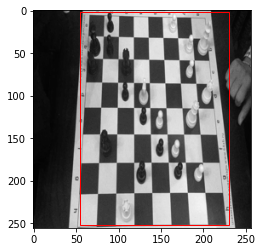

In [6]:
#plt.imshow(images[0])
import matplotlib.patches as patches
fig, ax = plt.subplots()

# Display the image
ax.imshow(images[0], cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((55,2), 175, 250, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# 4) Prepare files for train

In [7]:
# Create parent directory
directory = "./ChessBoardDataset"
os.mkdir(directory)
  
# Directory names
directory_labels = "labels"
directory_images = "images"
  
# Parent Directory path
parent_dir = "./ChessBoardDataset"
  
# Path
path_images = os.path.join(parent_dir, directory_images)
path_labels = os.path.join(parent_dir, directory_labels)
  
# Create the directories
os.mkdir(path_images)
os.mkdir(path_labels)

In [8]:
def convert_to_yolov5(array):
    print_buffer = []
    
    # For each bounding box
    for i, box in enumerate(array):
        class_id = 0
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        y_max = box[1::2].max()
        y_min = box[1::2].min()
        x_max = box[::2].max()
        x_min = box[::2].min()
        
        b_center_x = (x_max + x_min) / 2 
        b_center_y = (y_min + y_max) / 2
        b_width    = (x_max - x_min)
        b_height   = (y_max - y_min)
        
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
        # Name of the file which we have to save 
        save_file_name = os.path.join("./ChessBoardDataset/labels", f"{i}.txt")
    
        # Save the annotation to disk
        print("\n".join(print_buffer), file= open(save_file_name, "w"))
        print_buffer.clear()
        
convert_to_yolov5(labels)

In [9]:
def save_images(path, array):
    pbar = tqdm(array)
    for i, image in enumerate(pbar):
        imsave(f'{path}{i}.png', image,  cmap='gray')

save_images('./ChessBoardDataset/images/',images.squeeze(3))


100%|██████████| 5000/5000 [01:43<00:00, 48.54it/s]


In [10]:
test_im = np.load('../input/chessboarddetection/xtest.npy')
os.mkdir('./test_images')
save_images('./test_images/',test_im.squeeze(3))

100%|██████████| 5/5 [00:00<00:00, 50.91it/s]


In [11]:
file1 = open("./yolov5/data/ChessBoardData.yaml","w")
L = ['path: ./ChessBoardDataset \n', 'train: images \n' , 'val: images \n', 'nc: 1 \n' , 'names: ["board"] \n']
  
# \n is placed to indicate EOL (End of Line)
file1.writelines(L)
file1.close() #to change file access modes
  
file1 = open("./yolov5/data/ChessBoardData.yaml","r+") 
  
print("Output of Read function is ")
print (file1.read())

Output of Read function is 
path: ./ChessBoardDataset 
train: images 
val: images 
nc: 1 
names: ["board"] 



# 5)Train YOLOv5s

In [12]:
# Weights & Biases  (optional)
# e6f937fc3cb25d7b89f8b95e44768562ae84a438
%pip install -q wandb
import wandb
#wandb.login()

Note: you may need to restart the kernel to use updated packages.


In [13]:
!wandb disabled

W&B disabled.


In [14]:
!python yolov5/train.py --img 640 --batch 8 --epochs 10 --data ChessBoardData.yaml --weights yolov5s.pt 

100%|████████████████████████████████████████| 755k/755k [00:00<00:00, 36.4MB/s]
train: weights=yolov5s.pt, cfg=, data=ChessBoardData.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=10, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=30
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
2021-08-30 19:59:33.279987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
100%|██████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 53.5MB/s]

train: Scanning 'ChessBoar

# 6) Inference and results visualization 

In [15]:
test_image = np.load('../input/chessboarddetection/xtest.npy')
test_image.shape

(5, 256, 256, 1)

In [16]:
!python yolov5/detect.py --source ./test_images --weights runs/train/exp/weights/best.pt --conf 0.25 

detect: weights=['runs/train/exp/weights/best.pt'], source=./test_images, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
requirements: /kaggle/working/requirements.txt not found, check failed.
image 1/5 /kaggle/working/test_images/0.png: 640x640 1 board, Done. (0.022s)
image 2/5 /kaggle/working/test_images/1.png: 640x640 1 board, Done. (0.019s)
image 3/5 /kaggle/working/test_images/2.png: 640x640 1 board, Done. (0.023s)
image 4/5 /kaggle/working/test_images/3.png: 640x640 1 board, Done. (0.019s)
image 5/5 /kaggle/working/test_images/4.png: 640x640 1 board, Done. (0.019s)
Results saved to runs/detect/exp
Done. (0.157s)


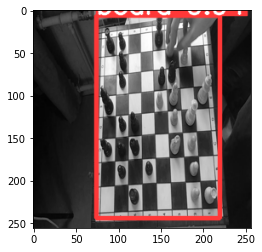

In [17]:
detections_dir = "runs/detect/exp"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

## We have only 5 grayscale images to test,let's vizualize them


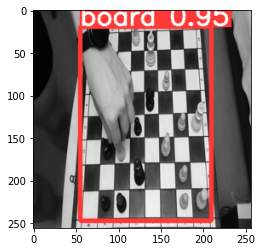

In [18]:
plt.imshow(np.array(Image.open('runs/detect/exp/0.png')))

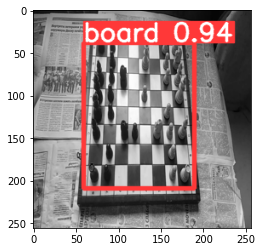

In [19]:
plt.imshow(np.array(Image.open('runs/detect/exp/1.png')))

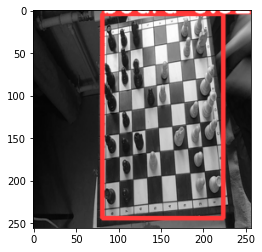

In [20]:
plt.imshow(np.array(Image.open('runs/detect/exp/2.png')))

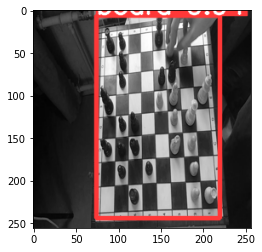

In [21]:
plt.imshow(np.array(Image.open('runs/detect/exp/3.png')))

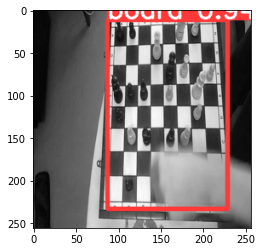

In [22]:
plt.imshow(np.array(Image.open('runs/detect/exp/4.png')))

# 7)Download the weights

In [23]:
from IPython.display import FileLink 
FileLink(r'runs/train/exp2/weights/best.pt')

/kaggle/working/runs/train/exp2/weights/best.pt